# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [2]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Computer\AppData\Local\Temp\pip-install-d7om_717\tensorflow-gpu_4de45126a0f044e884edde6f010e33a7\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did 

In [3]:
!pip install  opencv-python

In [4]:
!pip install  matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [5]:
import os
import time
import uuid
import cv2

In [5]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [18]:
import cv2
import os
import uuid
import time

# Set the number of frames to capture
number_images = 60

# Create a directory to store the images
IMAGES_PATH = "images"
os.makedirs(IMAGES_PATH, exist_ok=True)

# Initialize video capture
cap = cv2.VideoCapture(0)  # Use 0 instead of 1 for the default camera

for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))

    # Capture frame
    ret, frame = cap.read()

    # Check if frame capture was successful
    if ret:
        imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
        cv2.waitKey(1)  # Display the frame for 1 millisecond
        time.sleep(0.5)  # Adjust delay as needed
    else:
        print(f'Failed to capture frame {imgnum}. Error code: {ret}')

# Release resources
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [48]:
!labelme

2024-04-23 13:15:44,397 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Computer\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [8]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [ ]:
images.as_numpy_iterator().next()

In [9]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [39]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

### 2.4 View Raw Images with Matplotlib

In [10]:
image_generator = images.batch(4).as_numpy_iterator()

NameError: name 'images' is not defined

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [49]:
180*.7 # 125 to train

125.99999999999999

In [55]:
180*.15 # 27 and 28 to test and val

27.0

In [56]:
125+55

180

### 3.2 Move the Matching Labels

In [11]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [10]:
import albumentations as alb

In [11]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [12]:
img = cv2.imread(os.path.join('data','train', 'images','8320b4db-00d3-11ef-8754-0028f88277aa.jpg'))

In [13]:
img.shape

(480, 640, 3)

In [14]:
with open(os.path.join('data', 'train', 'labels', '8320b4db-00d3-11ef-8754-0028f88277aa.json'), 'r') as f:
    label = json.load(f)

In [15]:
label['shapes'][0]['points']

[[219.73958333333337, 60.31249999999998], [516.09375, 408.22916666666663]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [16]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [18]:
coords

[219.73958333333337, 60.31249999999998, 516.09375, 408.22916666666663]

In [19]:
coords = list(np.divide(coords, [640,480,640,480]))

In [20]:
coords

[0.34334309895833337, 0.12565104166666663, 0.806396484375, 0.8504774305555555]

### 4.4 Apply Augmentations and View Results

In [21]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [22]:
augmented['bboxes'][0][2:]

(0.785023148148148, 0.8904166666666667)

In [23]:
augmented['bboxes']

[(0.12645833333333334,
  0.1172685185185186,
  0.785023148148148,
  0.8904166666666667)]

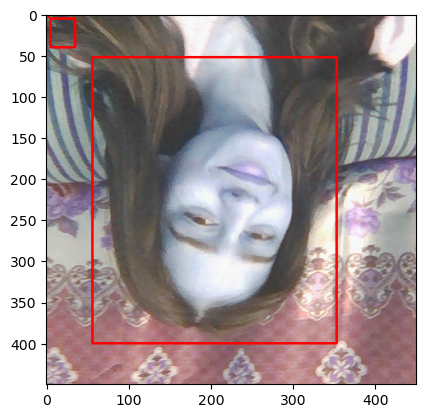

In [289]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [26]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.3758951822916667, 0.802734375, 0.011311848958333325, 0.1104600694444444, 'face'].
x_max is less than or equal to x_min for bbox [0.2635904947916667, 0.6888020833333334, 0.004801432291666652, 0.21028645833333331, 'face'].
x_max is less than or equal to x_min for bbox [0.8299967447916667, 0.8949652777777778, 0.2562662760416667, 0.17990451388888884, 'face'].
x_max is less than or equal to x_min for bbox [0.908935546875, 0.9752604166666666, 0.31892903645833337, 0.22981770833333331, 'face'].
x_max is less than or equal to x_min for bbox [0.28230794270833337, 0.8602430555555555, 0.0, 0.33682232057701467, 'face'].
x_max is less than or equal to x_min for bbox [0.899169921875, 0.9437934027777778, 0.266845703125, 0.2276475694444444, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [25]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [26]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [27]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [28]:
train_images.as_numpy_iterator().next()

array([[[0.24136029, 0.16691177, 0.13008578],
        [0.27150735, 0.18345588, 0.16678922],
        [0.29099265, 0.19295344, 0.20814951],
        ...,
        [0.72414213, 0.7751838 , 0.78020835],
        [0.71574754, 0.7853554 , 0.79221815],
        [0.71066177, 0.78566176, 0.8166054 ]],

       [[0.29681373, 0.21280637, 0.14613971],
        [0.30661765, 0.2129902 , 0.1747549 ],
        [0.30496323, 0.21770833, 0.22457108],
        ...,
        [0.7500613 , 0.78927696, 0.7936887 ],
        [0.7343137 , 0.7868872 , 0.79172796],
        [0.7434436 , 0.7996324 , 0.8061887 ]],

       [[0.2564951 , 0.21875   , 0.12990196],
        [0.297549  , 0.22640932, 0.17254902],
        [0.3011642 , 0.2291054 , 0.21390931],
        ...,
        [0.74313724, 0.80085784, 0.8126838 ],
        [0.7632353 , 0.7985294 , 0.82598037],
        [0.7384191 , 0.7889093 , 0.79724264]],

       ...,

       [[0.56985295, 0.6155025 , 0.6819853 ],
        [0.59993875, 0.61580884, 0.65974265],
        [0.60808825, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [29]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [30]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [32]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [33]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2399, 0.3447, 0.787 , 0.9336], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [34]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7248, 7140, 1745, 1620, 1680, 1680)

### 7.2 Create Final Datasets (Images/Labels)

In [35]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [36]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [37]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [38]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

### 7.3 View Images and Annotations

In [111]:
data_samples = train.as_numpy_iterator()

In [112]:
data_samples

In [221]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


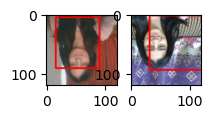

In [220]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(2,2))
for idx in range(2): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    sample_image_umat = cv2.UMat(sample_image)  # Convert to UMat
    
    cv2.rectangle(sample_image_umat, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  (255,0,0), 2)

    ax[idx].imshow(sample_image_umat.get())  # Convert back to NumPy array for visualization

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [52]:
vgg = VGG16(include_top=False)

In [53]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [54]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [55]:
facetracker = build_model()

In [56]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [57]:
X, y = train.as_numpy_iterator().next()

In [58]:
X.shape

(8, 120, 120, 3)

In [59]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [60]:
classes, coords

(array([[0.6230478 ],
        [0.5226348 ],
        [0.62090576],
        [0.5656733 ],
        [0.5649991 ],
        [0.54261225],
        [0.631094  ],
        [0.5590043 ]], dtype=float32),
 array([[0.41650143, 0.6059952 , 0.6639341 , 0.56947696],
        [0.48584506, 0.6662046 , 0.5753207 , 0.4930787 ],
        [0.4968375 , 0.62846446, 0.68508327, 0.46709794],
        [0.4935765 , 0.5994388 , 0.7072449 , 0.61054295],
        [0.4043766 , 0.5967258 , 0.5924022 , 0.5302819 ],
        [0.46386018, 0.6212354 , 0.7206175 , 0.5196013 ],
        [0.42874393, 0.67712736, 0.68027997, 0.5016522 ],
        [0.40322375, 0.6950601 , 0.6394331 , 0.5302619 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [61]:
len(train)

893

In [62]:
batches_per_epoch = 893
lr_decay = (1./0.75 -1)/batches_per_epoch

In [63]:
lr_decay

0.0003732736095558043

In [64]:
import tensorflow as tf
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [65]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [66]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [67]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.539465>

In [68]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.54906344>

In [69]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.539465>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [70]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [71]:
model = FaceTracker(facetracker)

In [72]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [73]:
logdir='logs'

In [74]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
893/893 [==============================] - 3434s 4s/step - total_loss: 1.0274 - class_loss: 0.2516 - regress_loss: 0.9016 - val_total_loss: 3.2477 - val_class_loss: 1.1869 - val_regress_loss: 2.6543
Epoch 2/10
893/893 [==============================] - 3604s 4s/step - total_loss: 0.7596 - class_loss: 0.1582 - regress_loss: 0.6805 - val_total_loss: 3.2890 - val_class_loss: 1.0801 - val_regress_loss: 2.7489
Epoch 3/10
893/893 [==============================] - 3337s 4s/step - total_loss: 0.6570 - class_loss: 0.1237 - regress_loss: 0.5952 - val_total_loss: 3.7399 - val_class_loss: 1.3759 - val_regress_loss: 3.0519
Epoch 4/10
893/893 [==============================] - 3187s 4s/step - total_loss: 0.5768 - class_loss: 0.0975 - regress_loss: 0.5281 - val_total_loss: 3.9104 - val_class_loss: 1.4422 - val_regress_loss: 3.1893
Epoch 5/10
812/893 [==========================>...] - ETA: 4:02 - total_loss: 0.5315 - class_loss: 0.0863 - regress_loss: 0.4884

In [ ]:
hist = model.fit(train, epochs=4, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/4
893/893 [==============================] - 2161s 2s/step - total_loss: 1.0611 - class_loss: 0.2611 - regress_loss: 0.9306 - val_total_loss: 2.9681 - val_class_loss: 0.9012 - val_regress_loss: 2.5175
Epoch 2/4
488/893 [===============>..............] - ETA: 14:53 - total_loss: 0.8055 - class_loss: 0.1741 - regress_loss: 0.7184

 final training on following parameters

In [75]:
hist = model.fit(train, epochs=6, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/6
893/893 [==============================] - 2461s 3s/step - total_loss: 1.0690 - class_loss: 0.2690 - regress_loss: 0.9346 - val_total_loss: 3.1664 - val_class_loss: 1.2630 - val_regress_loss: 2.5349
Epoch 2/6
893/893 [==============================] - 2530s 3s/step - total_loss: 0.7964 - class_loss: 0.1762 - regress_loss: 0.7083 - val_total_loss: 3.0112 - val_class_loss: 0.9904 - val_regress_loss: 2.5160
Epoch 3/6
893/893 [==============================] - 2442s 3s/step - total_loss: 0.6529 - class_loss: 0.1229 - regress_loss: 0.5915 - val_total_loss: 4.9322 - val_class_loss: 1.8040 - val_regress_loss: 4.0302
Epoch 4/6
893/893 [==============================] - 2419s 3s/step - total_loss: 0.5880 - class_loss: 0.1038 - regress_loss: 0.5361 - val_total_loss: 3.6207 - val_class_loss: 1.2245 - val_regress_loss: 3.0085
Epoch 5/6
893/893 [==============================] - 2358s 3s/step - total_loss: 0.5464 - class_loss: 0.0914 - regress_loss: 0.5007 - val_total_loss: 3.2408 - val_c

### 10.3 Plot Performance

In [76]:
hist.history

{'total_loss': [0.27117621898651123,
  0.43171826004981995,
  0.4246556758880615,
  0.0678386315703392,
  0.10874461382627487,
  0.18816711008548737],
 'class_loss': [0.036681946367025375,
  0.1341761350631714,
  0.17337539792060852,
  0.0001947887212736532,
  0.00013150667655281723,
  0.047165293246507645],
 'regress_loss': [0.2528352439403534,
  0.36463019251823425,
  0.33796799182891846,
  0.06774123758077621,
  0.10867886245250702,
  0.1645844578742981],
 'val_total_loss': [3.1663973331451416,
  3.0111796855926514,
  4.932160377502441,
  3.6206915378570557,
  3.240795135498047,
  4.372920989990234],
 'val_class_loss': [1.2629976272583008,
  0.9903843998908997,
  1.8039813041687012,
  1.22446870803833,
  1.3026294708251953,
  2.1029558181762695],
 'val_regress_loss': [2.534898519515991,
  2.5159873962402344,
  4.030169486999512,
  3.0084571838378906,
  2.589480400085449,
  3.3214433193206787]}

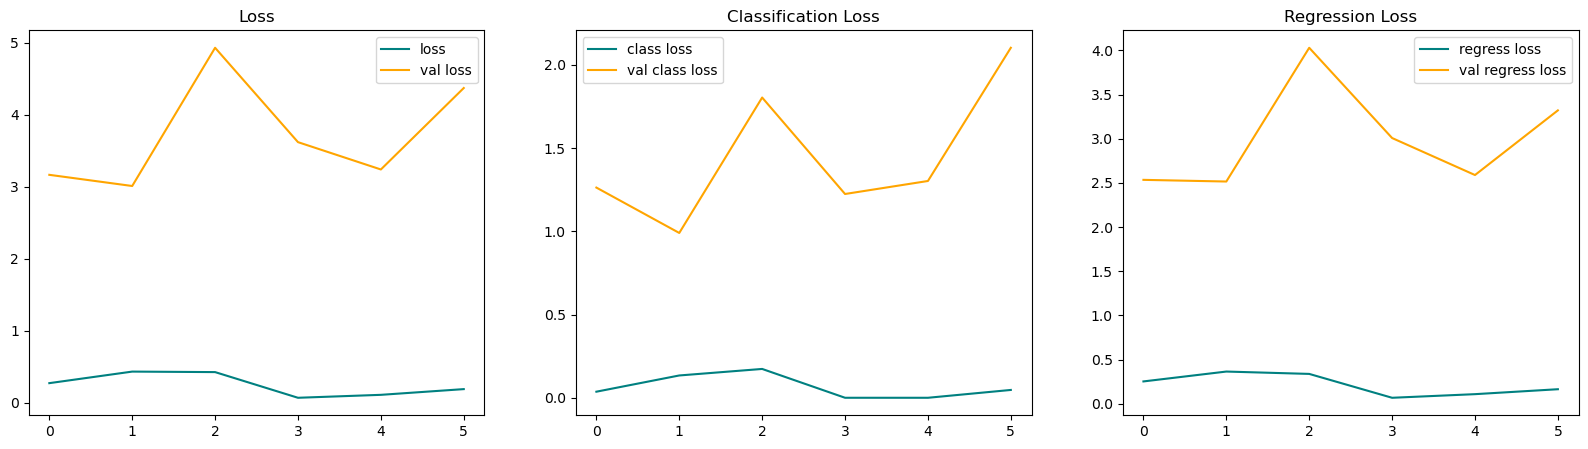

In [77]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

val loss had more better bet fit line than the loss's best fit line, in loss, classification loss and regression loss. (all three)

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [78]:
test_data = test.as_numpy_iterator()

In [279]:
test_sample = test_data.next()

In [280]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


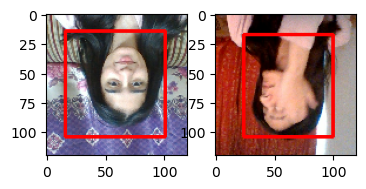

In [281]:
fig, ax = plt.subplots(ncols=2, figsize=(4, 4))
for idx in range(2): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        sample_image_copy = sample_image.copy()  # Create a copy of the image
        cv2.rectangle(sample_image_copy, 
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                      (255, 0, 0), 2)
        ax[idx].imshow(sample_image_copy)
    else:
        ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [2]:
from tensorflow.keras.models import load_model

In [85]:
facetracker.save('facetracker.h5')

C:\Users\Computer\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
import cv2
import tensorflow as tf
import numpy as np

# Load the face tracking model (facetracker) and other necessary configurations

cap = cv2.VideoCapture(0)  # Use default camera (index 0)

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame = frame[50:500, 50:500, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                    [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                    [80, 0])),
                      (255, 0, 0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                 [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()